Data size before removing N/A cell rows, Total:  286 | Removed, Rows with NA:  0


HBox()

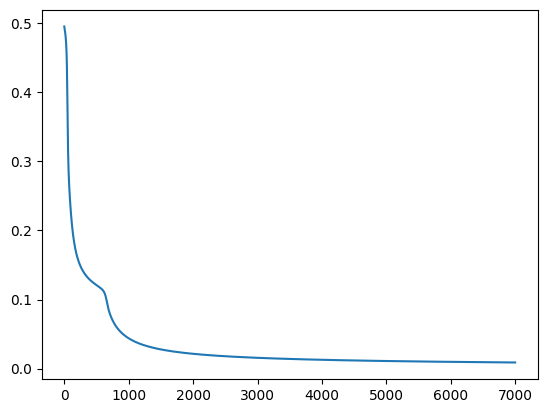

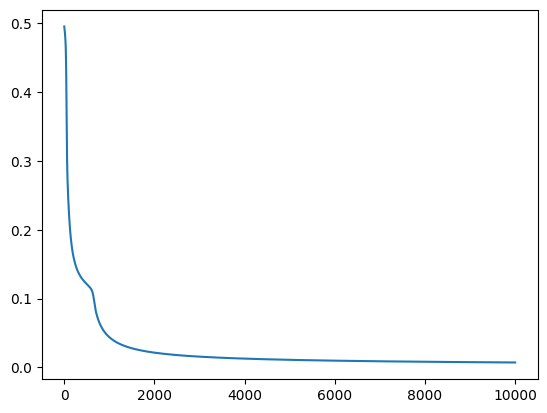

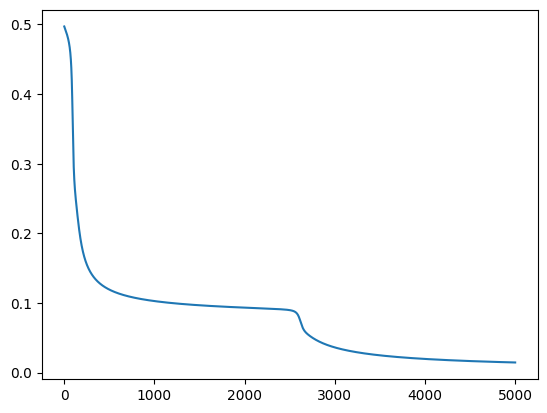

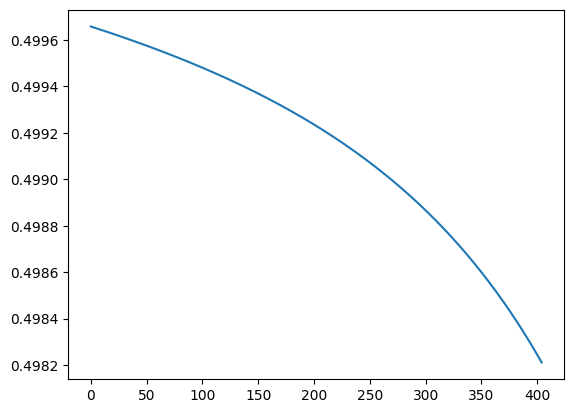

In [8]:
from unittest.mock import inplace

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import re



######## Widgets for easy control ##########

from IPython.core.display_functions import display
import ipywidgets as widget
from ipywidgets import HBox, VBox, Output

style = {'description_width': '150px',"button_width":"150px"}
layout = {'width': '400px'}
status_Widget = widget.HTML(
    placeholder='<h1> Status: <h1><br> ',
    value= "",
    layout=layout
)
training_rate_set = widget.FloatLogSlider(
    value=0.01,
    min=0.00,
    max=0.99,
    step=0.01,
    readout=True,
    description="Learning Rate multiplier",
    layout=layout,
    style=style,
)
weight1_multiplier_slider = widget.FloatLogSlider(
    value=1.0,
    min=0.01,
    max=2.50,
    step=0.01,
    readout=True,
    description="Initial Weight1",
    layout=layout,
    style=style,
    button_style='info',
    set=True,
    disabled=False,
)
weight2_multiplier_slider = widget.FloatLogSlider(
    value=1.0,
    min=0.01,
    max=2.50,
    step=0.01,
    readout=True,
    description="Initial Weight2",
    layout=layout,
    style=style,
    button_style='info',
    set=True,
    disabled=False,

)
itteration_slider = widget.IntSlider(
    value=5000,
    min=5,
    max=8000,
    step=5,
    readout=True,
    description="Training Loop",
    layout=layout,
    style=style,
    button_style='alert',
    set=True,
    disabled=False,

)
######## Widgets for easy control ##########

######## Setting widgets and default values ##########

%matplotlib inline
pd.set_option('future.no_silent_downcasting', True)
pd.options.mode.copy_on_write = True

global predictiontable, weight1, weight2,X,Y,data

def default_values(b):
    try:
        global learning_rate,loop_count,error,weight1_multiplier,weight2_multiplier
        learning_rate = 0.01
        loop_count = 5000
        error = []
        weight1_multiplier = 1  # User controllable variables
        weight2_multiplier = 1
    except Exception as Ex:
        status_Widget.value += "failed to reset value"

default_values("sample")
Log = widget.Output()

######## Setting widgets and default values ##########



data = pd.DataFrame( pd.read_excel('./breast-cancer.xls') )  # Data Import from local/ Drive file
original_data = data.copy()




################# Data sanitisation #################
try: 
    total_rows = len(data)
    print("Data size before removing N/A cell rows, Total: ", total_rows, end="")
    data.dropna(inplace=True) # Drops all NA cells by row and saves it back to source data
    print(" | Removed, Rows with NA: ", total_rows - len(data))
except:
    status_Widget.value += "\nFailed to remove Null filled rows\n"

def data_cleancing(b):  
    
    global data,numeric_Translation_Menopause,numeric_Translation_NodeCaps,numeric_Translation_Breast,numeric_Translation_irradiat,numeric_Translation_Class
    try: 
        for x in data.index:
            if re.search( r"^[0-9]{1,2}-[0-9]{1,2}$",  str(data.loc[x, "age"]) ) is None and not ( re.search( r"^[0-9]{1,2}$",  str(data.loc[x, "age"])is None) ): #Using RegEx to confirm age pattern is not "XX-XX" / "X-XX" and not "XX"
                data.drop(index=x, inplace=True)
            elif re.search(r"^(ge40)$|^(premeno)$|^(lt40)$", str(data.loc[x, "menopause"])) is None:  #Using RegEx to confirm menopause name is only 1 of three
                data.drop(index=x, inplace=True)
            elif re.search(r"^[0-9]{1,2}-[0-9]{1,2}$", str(data.loc[x, "tumor-size"]) ) is None:  #Using RegEx to confirm tumor size is formated correctly
                data.drop(index=x, inplace=True)
            elif re.search(r"^[0-9]{1,2}-[0-9]{1,2}$", str(data.loc[x, "inv-nodes"])) is None: #Using RegEx to confirm node-caps is only yes or no Upper or lower case
                data.drop(index=x, inplace=True)
            elif re.match(r'^([Yy][eE][Ss]|[Nn][oO])$', str(data.loc[x, "node-caps"])) is None:  #Using RegEx to confirm inv-nodes count is a number range
                data.drop(index=x, inplace=True)
            elif re.search(r"^1$|^2$|^3$", str(data.loc[x, "deg-malig"])) is None:  #Using RegEx to confirm inv-nodes count is a number range
                data.drop(index=x, inplace=True)
            elif re.search(r"^([Ll][eE][fF][tT]|[Rr][Ii][Gg][hH][tT])$", str(data.loc[x, "breast"])) is None:  #Using RegEx to confirm inv-nodes count is a number range
                data.drop(index=x)
            elif re.search(r"^(left_up|left_low|central|right_up|right_low)$", str(data.loc[x, "breast-quad"]), re.IGNORECASE) is None:
                data.drop(index=x)#Using RegEx to confirm inv-nodes count is a number range

            #Force only standard answer for this query, Yes / Recurence will = Recurrence-event, anything with no / non = Non-recurrence-event
            elif re.search(r"(non|no|recurrence|Yes)", str(data.loc[x, "Class"]), re.IGNORECASE) is None:
                data.loc[x, "Class"] = "Non-recurrence-event"
            else:
                data.loc[x, "Class"] = "Recurrence-event"
                data.drop(index=x)
        range_median('age')
        range_median('tumor-size')
        range_median('inv-nodes')
        numeric_Translation_Menopause = uniques_translator('menopause', False)
        numeric_Translation_NodeCaps = uniques_translator('node-caps', False)
        numeric_Translation_Breast = uniques_translator('breast', False)
        numeric_Translation_irradiat = uniques_translator('irradiat', False)
        numeric_Translation_Class = uniques_translator('Class', False)
        ##  Dictionary of the change to revert back later    ##

        ## Translating all string columns to int equivilant  ##
        uniques_translator('menopause', True)
        uniques_translator('node-caps', True)
        uniques_translator('breast-quad', True)
        uniques_translator('breast', True)
        uniques_translator('irradiat', True)
        uniques_translator('Class', True)

        ## Translating all string columns to int equivilant  ##
        
        
        ## Range medium finder for all non int only columns

        data = data[['age', 'menopause', 'tumor-size', 'inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat','Class']].apply(lambda e: (e - e.min()) / (e.max() - e.min()))
        status_Widget.value += f'\nCleaned data without issue, removed: { total_rows - len(data) } \n'

    except IndexError as Ie:
        status_Widget.value += f'\nTraining_data_sets Creation failed {Ie}\n' 
    except ValueError as Ve:
        status_Widget.value += f'\nTraining_data_sets Creation failed {Ve}\n' 
    except TypeError as Te:
        status_Widget.value += f'\n Training_data_sets Creation failed {Te}\n' 
    except Exception as Ex:
        
        status_Widget.value += f'\nFailed to complete database formatting -> {Ex}\n'
        status_Widget.value += Ex

        
data.reset_index(drop=True, inplace=True)  # Re indexes entire dataframe to fix deleted rows

################# Data sanitisation #################

################# Data Formating #################
def range_median(column):
    #status_Widget.value += '\n Range Medium Run on Column:\n' + column + "\n"
    main_array = []
    try:
        for y in data.index:
            value = str(data.loc[y, column])
            if re.search(r"^[0-9]{1,2}-[0-9]{1,2}$", str(value)) is not None:
                array = np.array(re.findall(r"[0-9]{1,2}", value), dtype=int)
                main_array.append(np.median(array))

            elif  re.search( r"^[0-9]{1,2}$",  value)is not None:
                array = np.array(re.findall(r"[0-9]{1,2}", value), dtype=int)
                main_array.append(np.median(array))
        data[str(column)] = main_array
        return main_array
    except Exception as Ex:
        status_Widget.value += '\n Range Medium Run on Column Failed due to:\n' + Ex + "\n"

def uniques_translator(column, inpalce_trigger):
    try:
        #status_Widget.value += '\n Uniques_Translation Run on Column: ' + column 
        column_uniques = np.array(pd.unique(data[column]))
        translation_dictionary = {}
        for x in range(column_uniques.size):
            translation_dictionary.update({x : column_uniques[x]})
        if inpalce_trigger == True:
            data[str(column)] = data[[str(column)]].replace(column_uniques, translation_dictionary.keys())
            return data[[str(column)]]
        else:
            return data[[str(column)]].replace(column_uniques, translation_dictionary) , translation_dictionary
    except Exception as Ex:
        status_Widget.value += '\n Range Medium Run on Column:\n' + column + "\n"
##  Dictionary of the change to revert back later    ##








################# Data Formating #################

################# Training Data Masking #################

def data_sets_creation(b):
    global Training_Data,Testing_Data,X,Y,targets
    try:

        training_data_per =  90/100.0

        data['train'] = np.random.rand(len(data)) < training_data_per # Creates random array for each row  of Data, true or false using the fraction
        Training_Data = data[data.train == 1] # Appends train Data with the array for each row, effectively showing which row at random will be removed

        Training_Data = Training_Data.drop('train', axis=1).sample(frac=1)
        ################# Training Data Masking #################

        ################# Testing Data Seperation / Masking #################
        Testing_Data = data[data.train == 0]
        Testing_Data.drop('train', axis=1, inplace=True)

        Training_Data = data[data.train == 1]
        Training_Data.drop('train', axis=1, inplace=True)
        #Using X to remove Class colum as Y will be the opposite, As it is the diagnoses column
        #Y = 0  1
        #    1  0
        #    1  0
        #    1  0
        #    0  1
        # == [0,0,0,1.....]
        
        X = Training_Data.drop('Class', axis=1).to_numpy(dtype=float)

        targets = [[1,0],[0,1]]
        Y = np.array([targets[int(z[0])]  for z in Training_Data.values[:,8:9]])
        status_Widget.value += '\nDatasets created without issue\n'
        return Testing_Data,Testing_Data
    except IndexError as Ie:
        status_Widget.value += f'\nCreating Data sets Creation failed {Ie}' 
    except ValueError as Ve:
        status_Widget.value += f'\nCreating Data sets Creation failed {Ve}' 
    except TypeError as Te:
        status_Widget.value += f'\nCreating Data sets Creation failed {Te}' 
    except Exception as Ex:
        status_Widget.value += f'\nFailed to complete Creating Data sets -> {Ex}'
        
################# Testing Data Seperation / Masking #################

################# Backpropagating data creation #################



def weight_creation(b):
    global weight1,weight2

    try:
        NumberInput = len(X[0])
        Hidden_layer_Rows = 9
        rng = np.random.default_rng()

        weight1 = ( rng.uniform(-1, 1, (NumberInput, Hidden_layer_Rows)) - 1 ) * weight1_multiplier
        NumberOutputs = len(Y[0])
        weight2 = ( np.random.random((Hidden_layer_Rows, NumberOutputs)) - 1 ) * weight2_multiplier

        #Weight1 is [9 Columns]         and  [X length Rows]
        #Weight2 is [Y length Columns]  and  [ 4 Rows]
        # For Matrix Multiplication operation later
        status_Widget.value += '\Completed creation of weights'

    except:
        status_Widget.value += '\nFailed to create propegation Weights\n'


################# Backpropagating data creation #################


def train(b):
    status_Widget.value += f'\n Testing Begun, Running {loop_count} \n'
    global weight1, weight2,error                     #####Currently X is not being see
    try:
        for epoch in range(loop_count):
            # X shape = 166, 9
            # weight1 = 9,9
            # weight2 = 9,2

            l1 = 1/(1 + np.exp(-(X @ weight1))) # shape (166, 9)

            l2 = 1/(1 + np.exp(-(l1 @ weight2))) # (166, 2)
            er = (abs(Y - l2)).mean()
            error.append(er)

            l2_delta = (Y - l2)*(l2 * (1-l2)) 
            weight2 += l1.T.dot(l2_delta) * learning_rate

            l1_delta = l2_delta.dot(weight2.T) * (l1 * (1-l1))
            weight1 += X.T.dot(l1_delta) * learning_rate
        status_Widget.value += '\n Training Complete without issue \n'
    except ValueError as Ve:
        status_Widget.value += f'\nTraining failed {Ve}' 
    except TypeError as Te:
        status_Widget.value += f'\nTraining failed {Te}' 
    except Exception as Ex:
        status_Widget.value += f'\nTraining failed -> {Ex}'



# taken from> https://gist.github.com/craffel/2d727968c3aaebd10359
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

#fig = plt.figure(figsize=(5, 5))
#ax = fig.gca()
#ax.axis('off')
#draw_neural_net(ax, .1, .9, .1, .9, [9, 2, 1])

def testing(b):
    global predictiontable
    try:
        X_testing = pd.DataFrame(Testing_Data.drop('Class', axis=1).values.astype(float))   # shape (length, 9)
        status_Widget.value += "Step0"
        Y_Testing = np.array([targets[int(r[0])]  for r in Testing_Data.values])
        l1 = 1/(1 + np.exp(-(X_testing @ weight1)))
        l2 = 1/(1 + np.exp(-(l1 @ weight2)))
        y_prediction = np.argmax(l2 , axis = 1)
        status_Widget.value += "Step1"
        resolution = y_prediction == np.argmax(Testing_Data['Class'], axis=0)
        status_Widget.value += "Step2"
        correct = np.sum(resolution)/len(resolution)
        status_Widget.value += "Step3"
        predictiontable = Testing_Data['Class'].replace([0,1], ['recurrence-events', 'no-recurrence-events']).to_frame().reset_index()
        predictiontable['prediction'] = pd.Series(resolution).replace([False,True], ['recurrence-events', 'no-recurrence-events'])
        predictiontable['Check'] = (pd.Series(y_prediction) != np.argmax(Y_Testing, axis=1))
        predictiontable['Raw_value_l2'] = y_prediction
        predictiontable['original_Raw_value'] = Testing_Data['Class'].reset_index().drop('index', axis=1)
        status_Widget.value += "Step4"
        status_Widget.value += f'Correct: {sum(resolution)}/ {len(resolution)} : {(correct*100)}%'
    
    except Exception as Ex:  
        status_Widget.value += f'\n Failed to Test, Error: {Ex}'



######## Widgets for easy control +  functions ##########
def draw_error_graph(b):
    if  error :
        out = Output()
        with out:
            plt.plot(error)
        graphs.children = graphs.children 
    
        
    else:
        status_Widget.value += "\nNo Data to Plot"

Incoming_Sanatisation = widget.Button(
    set=False,
    description="Data Cleansing",
    disable=False,
    style=style
)
Data_sets_Creation = widget.Button(
    set=False,
    description="Data sets Creation",
    disable=False,
    style=style
)
Weight_Generator = widget.Button(
    set=False,
    description="Create Weights",
    disable=False,
    style=style
)

Training_trigger_button = widget.Button(
    set=False,
    description="Begin Trianing",
    disable=False,
    style=style
)

toggle_learning_graph_error = widget.Button(
    button_style='info',
    description="Error Plot Curve",
    disable=False,
    style=style,
    icon='question'
)
testing_output = widget.Button(
    button_style='warning',
    description="Test model",
    disable=False,
    style=style,
    icon='question'
)
reset_values = widget.Button(
    button_style='warning',
    description="Reset values",
    disable=False,
    style={'description_width': '150px',"button_width":"80px"},
    icon='restart'
)

def observer(change):
    global loop_count,learning_rate,weight1_multiplier,weight2_multiplier
    widget_Name = str(change["owner"].description) 

    global loop_count,learning_rate,weight1_multiplier,weight2_multiplier
    try:
        if widget_Name == "Initial Weight1":
            weight1_multiplier = weight1_multiplier_slider.value
        elif widget_Name == "Initial Weight2":
            weight2_multiplier = weight2_multiplier_slider.value
        elif widget_Name == "Learning Rate multiplier":
            learning_rate = training_rate_set.value
        elif widget_Name == "Training Loop":
            loop_count = itteration_slider.value
        else:
            status_Widget.value += "Failed to set value"
        #status_Widget.value += "\n Value set for " + widget_Name + "\n"
    except:
        status_Widget.value += "<br>Failed to follow through with user input <br>"



Incoming_Sanatisation.on_click(data_cleancing)
Data_sets_Creation.on_click(data_sets_creation)
Training_trigger_button.on_click(train)
Weight_Generator.on_click(weight_creation)
Training_trigger_button.on_click(train)
testing_output.on_click(testing)
reset_values.on_click(default_values)
toggle_learning_graph_error.on_click(draw_error_graph)
weight1_multiplier_slider.observe(observer, names='value')
weight2_multiplier_slider.observe(observer, names='value')
itteration_slider.observe(observer, "value")
training_rate_set.observe(observer,names='value')

graphs = HBox()

display(HBox([Incoming_Sanatisation, Data_sets_Creation,Weight_Generator, Training_trigger_button,  toggle_learning_graph_error,testing_output,reset_values ]))
display(HBox([training_rate_set,    weight2_multiplier_slider,  weight1_multiplier_slider, itteration_slider ]), HBox([status_Widget   ]))
display(graphs)


def auto_run():
    data_cleancing(1)
    data_sets_creation(1)
    weight_creation(1)
    train(1)
    draw_error_graph(1)
#auto_run()


######## Widgets for easy control +  functions ##########

